<a href="https://colab.research.google.com/github/deburky/model-validation/blob/main/Validating_new_generation_credit_risk_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Technical appendix to *Validating new generation credit risk models*


<div class="alert alert-info">
<b>Description:</b> This notebook contains a technical appendix to the post on the validation of new generation credit risk models.
</div>

In [1]:
%%capture
!pip3 install sklearn --upgrade
!pip3 install lightgbm --upgrade
!pip3 install autowoe --upgrade
!pip3 install mlxtend --upgrade
!pip3 install -U scikit-learn --upgrade
!pip3 install optuna --upgrade

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb

import sklearn
print(sklearn.__version__)
from sklearn.model_selection import train_test_split

from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from copy import deepcopy
import joblib

from autowoe import ReportDeco, AutoWoE

1.0.2


## Data

### Import data into Colab with via a json ([link](https://www.kaggle.com/general/74235))

Please follow the steps below to download and use kaggle data within Google Colab:

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

In [3]:
from google.colab import files

In [4]:
!pip3 install -q kaggle

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"deburky","key":"fb411c83ce3eddce6dc2ec21601da483"}'}

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# print datasets from Kaggle
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                          Diabetes Dataset                                      9KB  2022-10-06 08:55:25          16265        474  1.0              
akshaydattatraykhare/data-for-admission-in-the-university      Data for Admission in the University                  4KB  2022-10-27 11:05:45           4177         98  1.0              
thedevastator/jobs-dataset-from-glassdoor                      Salary Prediction                                     3MB  2022-11-16 13:52:31            716         26  1.0              
swaptr/layoffs-2022                                            La

#### Default of Credit Card Clients
##### Default Payments of Credit Card Clients in Taiwan from 2005

#### Sample Information
***
This sample contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

#### Features
***
There are 25 features in the sample:

*   `ID`: ID of each client
*   `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
*   `SEX`: Gender (1=male, 2=female)
*   `EDUCATION`: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
*   `MARRIAGE`: Marital status (1=married, 2=single, 3=others)
*   `AGE`: Age in years
*   `PAY_0`: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
*   `PAY_2`: Repayment status in August, 2005 (scale same as above)
*   `PAY_3`: Repayment status in July, 2005 (scale same as above)
*   `PAY_4`: Repayment status in June, 2005 (scale same as above)
*   `PAY_5`: Repayment status in May, 2005 (scale same as above)
*   `PAY_6`: Repayment status in April, 2005 (scale same as above)
*   `BILL_AMT1`: Amount of bill statement in September, 2005 (NT dollar)
*   `BILL_AMT2`: Amount of bill statement in August, 2005 (NT dollar)
*   `BILL_AMT3`: Amount of bill statement in July, 2005 (NT dollar)
*   `BILL_AMT4`: Amount of bill statement in June, 2005 (NT dollar)
*   `BILL_AMT5`: Amount of bill statement in May, 2005 (NT dollar)
*   `BILL_AMT6`: Amount of bill statement in April, 2005 (NT dollar)
*   `PAY_AMT1`: Amount of previous payment in September, 2005 (NT dollar)
*   `PAY_AMT2`: Amount of previous payment in August, 2005 (NT dollar)
*   `PAY_AMT3`: Amount of previous payment in July, 2005 (NT dollar)
*   `PAY_AMT4`: Amount of previous payment in June, 2005 (NT dollar)
*   `PAY_AMT5`: Amount of previous payment in May, 2005 (NT dollar)
*   `PAY_AMT6`: Amount of previous payment in April, 2005 (NT dollar)
*   `default.payment.next.month`: Default payment (1=yes, 0=no)

### Preparing data

In [9]:
!kaggle datasets download -d uciml/default-of-credit-card-clients-dataset # https://www.kaggle.com/general/156610

  0% 0.00/0.98M [00:00<?, ?B/s]
100% 0.98M/0.98M [00:00<00:00, 180MB/s]


In [10]:
!mkdir train

In [11]:
!unzip default-of-credit-card-clients-dataset.zip -d train

Archive:  default-of-credit-card-clients-dataset.zip
  inflating: train/UCI_Credit_Card.csv  


In [12]:
modeling_data = pd.read_csv('train/UCI_Credit_Card.csv')
modeling_data.drop('ID', axis=1, inplace=True)

In [13]:
modeling_data.describe().loc[['min', 'mean', 'max']].transpose()

,min,mean,max
LIMIT_BAL,10000.0,167484.322667,1000000.0
SEX,1.0,1.603733,2.0
EDUCATION,0.0,1.853133,6.0
MARRIAGE,0.0,1.551867,3.0
AGE,21.0,35.485500,79.0
PAY_0,-2.0,-0.016700,8.0
PAY_2,-2.0,-0.133767,8.0
PAY_3,-2.0,-0.166200,8.0
PAY_4,-2.0,-0.220667,8.0
PAY_5,-2.0,-0.266200,8.0


In [14]:
num_col = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', \
           'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

cat_col = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

num_feature_type = {x: "real" for x in num_col}
cat_feature_type = {x: "cat" for x in cat_col}

features_type = dict(**num_feature_type,
                     **cat_feature_type,)

In [15]:
features = cat_col + num_col
target = 'default.payment.next.month'

### Train/validation/test split
After splitting the data into training and testing datasets, the validation dataset is created by splitting the training dataset into two parts.


In [16]:
# splitting dataset into full train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    modeling_data[features], 
    modeling_data[target], 
    test_size=0.2, 
    random_state=62)

# splitting full train into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.25, 
    random_state=62)

# join features and the target together
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
validation = pd.concat([X_val, y_val], axis=1)

print(f"Train set: {train.shape}\nValidation set: {validation.shape}\nTest set: {test.shape}")

Train set: (18000, 24)
Validation set: (6000, 24)
Test set: (6000, 24)


## Development

Training the model with LightAutoML AutoWoE library

In [17]:
auto_woe = AutoWoE(
    task='BIN',
    interpreted_model=True,
    monotonic=False,
    max_bin_count=5,
    select_type=None,
    pearson_th=0.9,
    metric_th=.55,
    vif_th=10.,
    imp_th=0,
    th_const=32,
    force_single_split=True,
    th_nan=0.01,
    th_cat=0.005,
    woe_diff_th=0.01,
    min_bin_size=0.01,
    min_bin_mults=(2, 4),
    min_gains_to_split=(0.0, 0.5, 1.0),
    auc_tol=1e-4,
    cat_alpha=100,
    cat_merge_to="to_woe_0",
    nan_merge_to="to_woe_0",
    oof_woe=True,
    n_folds=6,
    n_jobs=4,
    l1_grid_size=20,
    l1_exp_scale=6,
    imp_type="feature_imp",
    regularized_refit=False,
    p_val=0.05,
    debug=False,
    verbose=0)

auto_woe = ReportDeco(auto_woe)

In [18]:
# training the model
auto_woe.fit(
    train[features + [target]], 
    target_name=str(target),
    group_kf=None,
    validation=test)

[LightGBM] [Info] Number of positive: 3217, number of negative: 11183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3260
[LightGBM] [Info] Number of data points in the train set: 14400, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223403 -> initscore=-1.245946
[LightGBM] [Info] Start training from score -1.245946


In [19]:
# saving the serialized model
joblib.dump(auto_woe.model, 'autowoe_model.pkl')
model = joblib.load('autowoe_model.pkl')

In [20]:
# testing discriminatory power
train_predictions = model.predict_proba(train)
print(f"Train Gini : {roc_auc_score(train[target], train_predictions)*2-1:.2%}")

test_predictions = model.predict_proba(test)
print(f"Test Gini : {roc_auc_score(test[target], test_predictions)*2-1:.2%}")

Train Gini : 53.95%
Test Gini : 56.13%


In [21]:
# SQL-like output
print(model.get_sql_inference_query('table'))

SELECT
  1 / (1 + EXP(-(
    -1.234
    -0.768*WOE_TAB.PAY_0
    -0.22*WOE_TAB.PAY_3
    -0.422*WOE_TAB.LIMIT_BAL
    -0.215*WOE_TAB.PAY_AMT1
    -0.234*WOE_TAB.PAY_5
    -0.282*WOE_TAB.PAY_AMT2
    -0.326*WOE_TAB.PAY_AMT3
    -0.219*WOE_TAB.PAY_6
  ))) as PROB,
  WOE_TAB.*
FROM 
    (SELECT
    CASE
      WHEN (PAY_0 IS NULL OR PAY_0 = 'NaN') THEN 0
      WHEN PAY_0 <= -1.5 THEN 0.596
      WHEN PAY_0 <= -0.0 THEN 0.299
      WHEN PAY_0 <= 0.0 THEN 0.666
      WHEN PAY_0 <= 1.5 THEN -0.586
      ELSE -2.082
    END AS PAY_0,
    CASE
      WHEN (PAY_3 IS NULL OR PAY_3 = 'NaN') THEN 0
      WHEN PAY_3 <= -1.5 THEN 0.246
      WHEN PAY_3 <= -0.0 THEN 0.395
      WHEN PAY_3 <= 0.0 THEN 0.297
      WHEN PAY_3 <= 2.5 THEN -1.331
      ELSE -1.661
    END AS PAY_3,
    CASE
      WHEN (LIMIT_BAL IS NULL OR LIMIT_BAL = 'NaN') THEN 0
      WHEN LIMIT_BAL <= 45000.0 THEN -0.714
      WHEN LIMIT_BAL <= 125000.0 THEN -0.187
      WHEN LIMIT_BAL <= 145000.0 THEN 0.012
      WHEN LIMIT_BAL <= 2650

In [22]:
model.get_woe('PAY_0')

('-inf', '-1.50')     0.595837
('-1.50', '-0.00')    0.299413
('-0.00', '0.00')     0.666357
('0.00', '1.50')     -0.586369
('1.50', 'inf')      -2.082435
__NaN_0__             0.000000
dtype: float64

## Validation
We will assess the following dimensions of model quality:

* **Model choice:** is there a simpler useful alternative that delivers similar predictive performance?
* **Model parsimony:** does the model include relevant features which are meaningful?
* **Model performance:** are the model's estimates stable and reliable?


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import graphviz
import seaborn as sns

In [24]:
# Final features
final_features = list(model.features_fit.index.values)
print(f"Final list of model features : {final_features}")

Final list of model features : ['PAY_0', 'PAY_3', 'LIMIT_BAL', 'PAY_AMT1', 'PAY_5', 'PAY_AMT2', 'PAY_AMT3', 'PAY_6']


### Development and validation data
We recreate the full development set (train + test) to use it for validation tests

In [25]:
# stacking train and test data together into development data
development = pd.concat([train, test]) 
print(f"Development set : {development.shape}\nValidation set : {validation.shape}")

Development set : (24000, 24)
Validation set : (6000, 24)


### Model choice

We challenge the modeling choice by running two challenger models with higher interpretability to see if we are able to achieve similar discriminatory power to the model being validated

In [26]:
def evaluate_predictions(
        clf, X_train, y_train,
        X_test, y_test, cv_scoring=False):
  
  """
  Evaluate predictions of the model
  Metric: Gini coefficient
  """
  
  train_predictions = clf.predict_proba(X_train)[:, 1]
  test_predictions = clf.predict_proba(X_test)[:, 1]

  train_gini = roc_auc_score(y_train, train_predictions)*2-1
  test_gini = roc_auc_score(y_test, test_predictions)*2-1

  if cv_scoring:
  # allow for cross-validation
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])

    cv_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')*2-1

  # saving the results
  results_dict = {'Train Gini coefficient': f"{train_gini:.2%}", 
                  'Test Gini coefficient': f"{test_gini:.2%}", 
                  'CV Gini coefficient': f"{cv_scores.mean():.2%}",
                  }

  # printing the scores
  for key in results_dict:
    print (f"{key}: {results_dict[key]}")

  return results_dict

In [27]:
# stratified K-Fold
skf = model_selection.StratifiedKFold(
    n_splits=10, 
    shuffle=True, 
    random_state=72)

#### Baseline 1: Logistic regression

In [28]:
# selecting numerical and categorical features from the final features
num = list(set(final_features) - set(cat_col))
cat = list(set(final_features) - set(num_col))
print(f"Numeric features : {num}\nCategorical features : {cat}")

Numeric features : ['LIMIT_BAL', 'PAY_AMT2', 'PAY_AMT1', 'PAY_AMT3']
Categorical features : ['PAY_5', 'PAY_0', 'PAY_6', 'PAY_3']


In [29]:
# mirroring statsmodels logistic regression
params = {"fit_intercept": True, 
          "penalty": "none",
          "random_state": 72,
          "solver": "newton-cg",         
          }

# one-hot encoding categorical features
transformer = ColumnTransformer(
    transformers=[('OneHotEncoder', OneHotEncoder(drop='first', handle_unknown='ignore'), cat)], 
    remainder='passthrough', 
    verbose_feature_names_out=False)

# creating a pipeline
sk_lr_model = make_pipeline(
    transformer,
    LogisticRegression(**params))

# training the model
sk_lr_model.fit(train[final_features], train[target])

# evaluating the model
evaluate_predictions(
    sk_lr_model, 
    train[final_features], 
    train[target], 
    test[final_features], 
    test[target], 
    cv_scoring=True)

Train Gini coefficient: 52.77%
Test Gini coefficient: 54.42%
CV Gini coefficient: 52.85%


{'Train Gini coefficient': '52.77%',
 'Test Gini coefficient': '54.42%',
 'CV Gini coefficient': '52.85%'}

#### Baseline 2: Decision Tree

In [30]:
def out_of_fold_prediction(
        clf, X, y, 
        folds, scale=False):
    
    prediction = y.copy()
    
    for i, (train_idx, test_idx) in enumerate(folds):
        
        X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx,:]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        clf.fit(X_train, y_train)
        
        prediction.iloc[test_idx] = clf.predict_proba(X_test)[:, 1]
        
    return(prediction)

In [31]:
scores = []
depths = [1, 3, 5, 6, 8, 10]

# training the model
for depth in depths:

    pred = out_of_fold_prediction(
        DecisionTreeClassifier(
            criterion='entropy',
            max_depth=depth,
#             class_weight='balanced',
            min_weight_fraction_leaf=0.05, 
            random_state=72),
        train[final_features], train[target], 
        skf.split(train[final_features], train[target]))

    gini = roc_auc_score(train[target], pred)*2-1

    scores.append(f"{gini:.2%}")

elements = list(zip(depths, scores))
model_outcomes = pd.DataFrame(elements, columns=['Tree Depth', 'Gini'])

print(model_outcomes)

   Tree Depth    Gini
0           1  27.16%
1           3  45.57%
2           5  49.12%
3           6  49.59%
4           8  49.72%
5          10  49.79%


In [32]:
# retraining based on cross-validated parameters
sk_dt_model = DecisionTreeClassifier(max_depth=6, min_weight_fraction_leaf=0.05)
sk_dt_model.fit(train[final_features], train[target])

# evaluating the model
evaluate_predictions(
    sk_dt_model,
    train[final_features],
    train[target],
    test[final_features],
    test[target],
    cv_scoring=True)

Train Gini coefficient: 51.06%
Test Gini coefficient: 52.52%
CV Gini coefficient: 50.81%


{'Train Gini coefficient': '51.06%',
 'Test Gini coefficient': '52.52%',
 'CV Gini coefficient': '50.81%'}

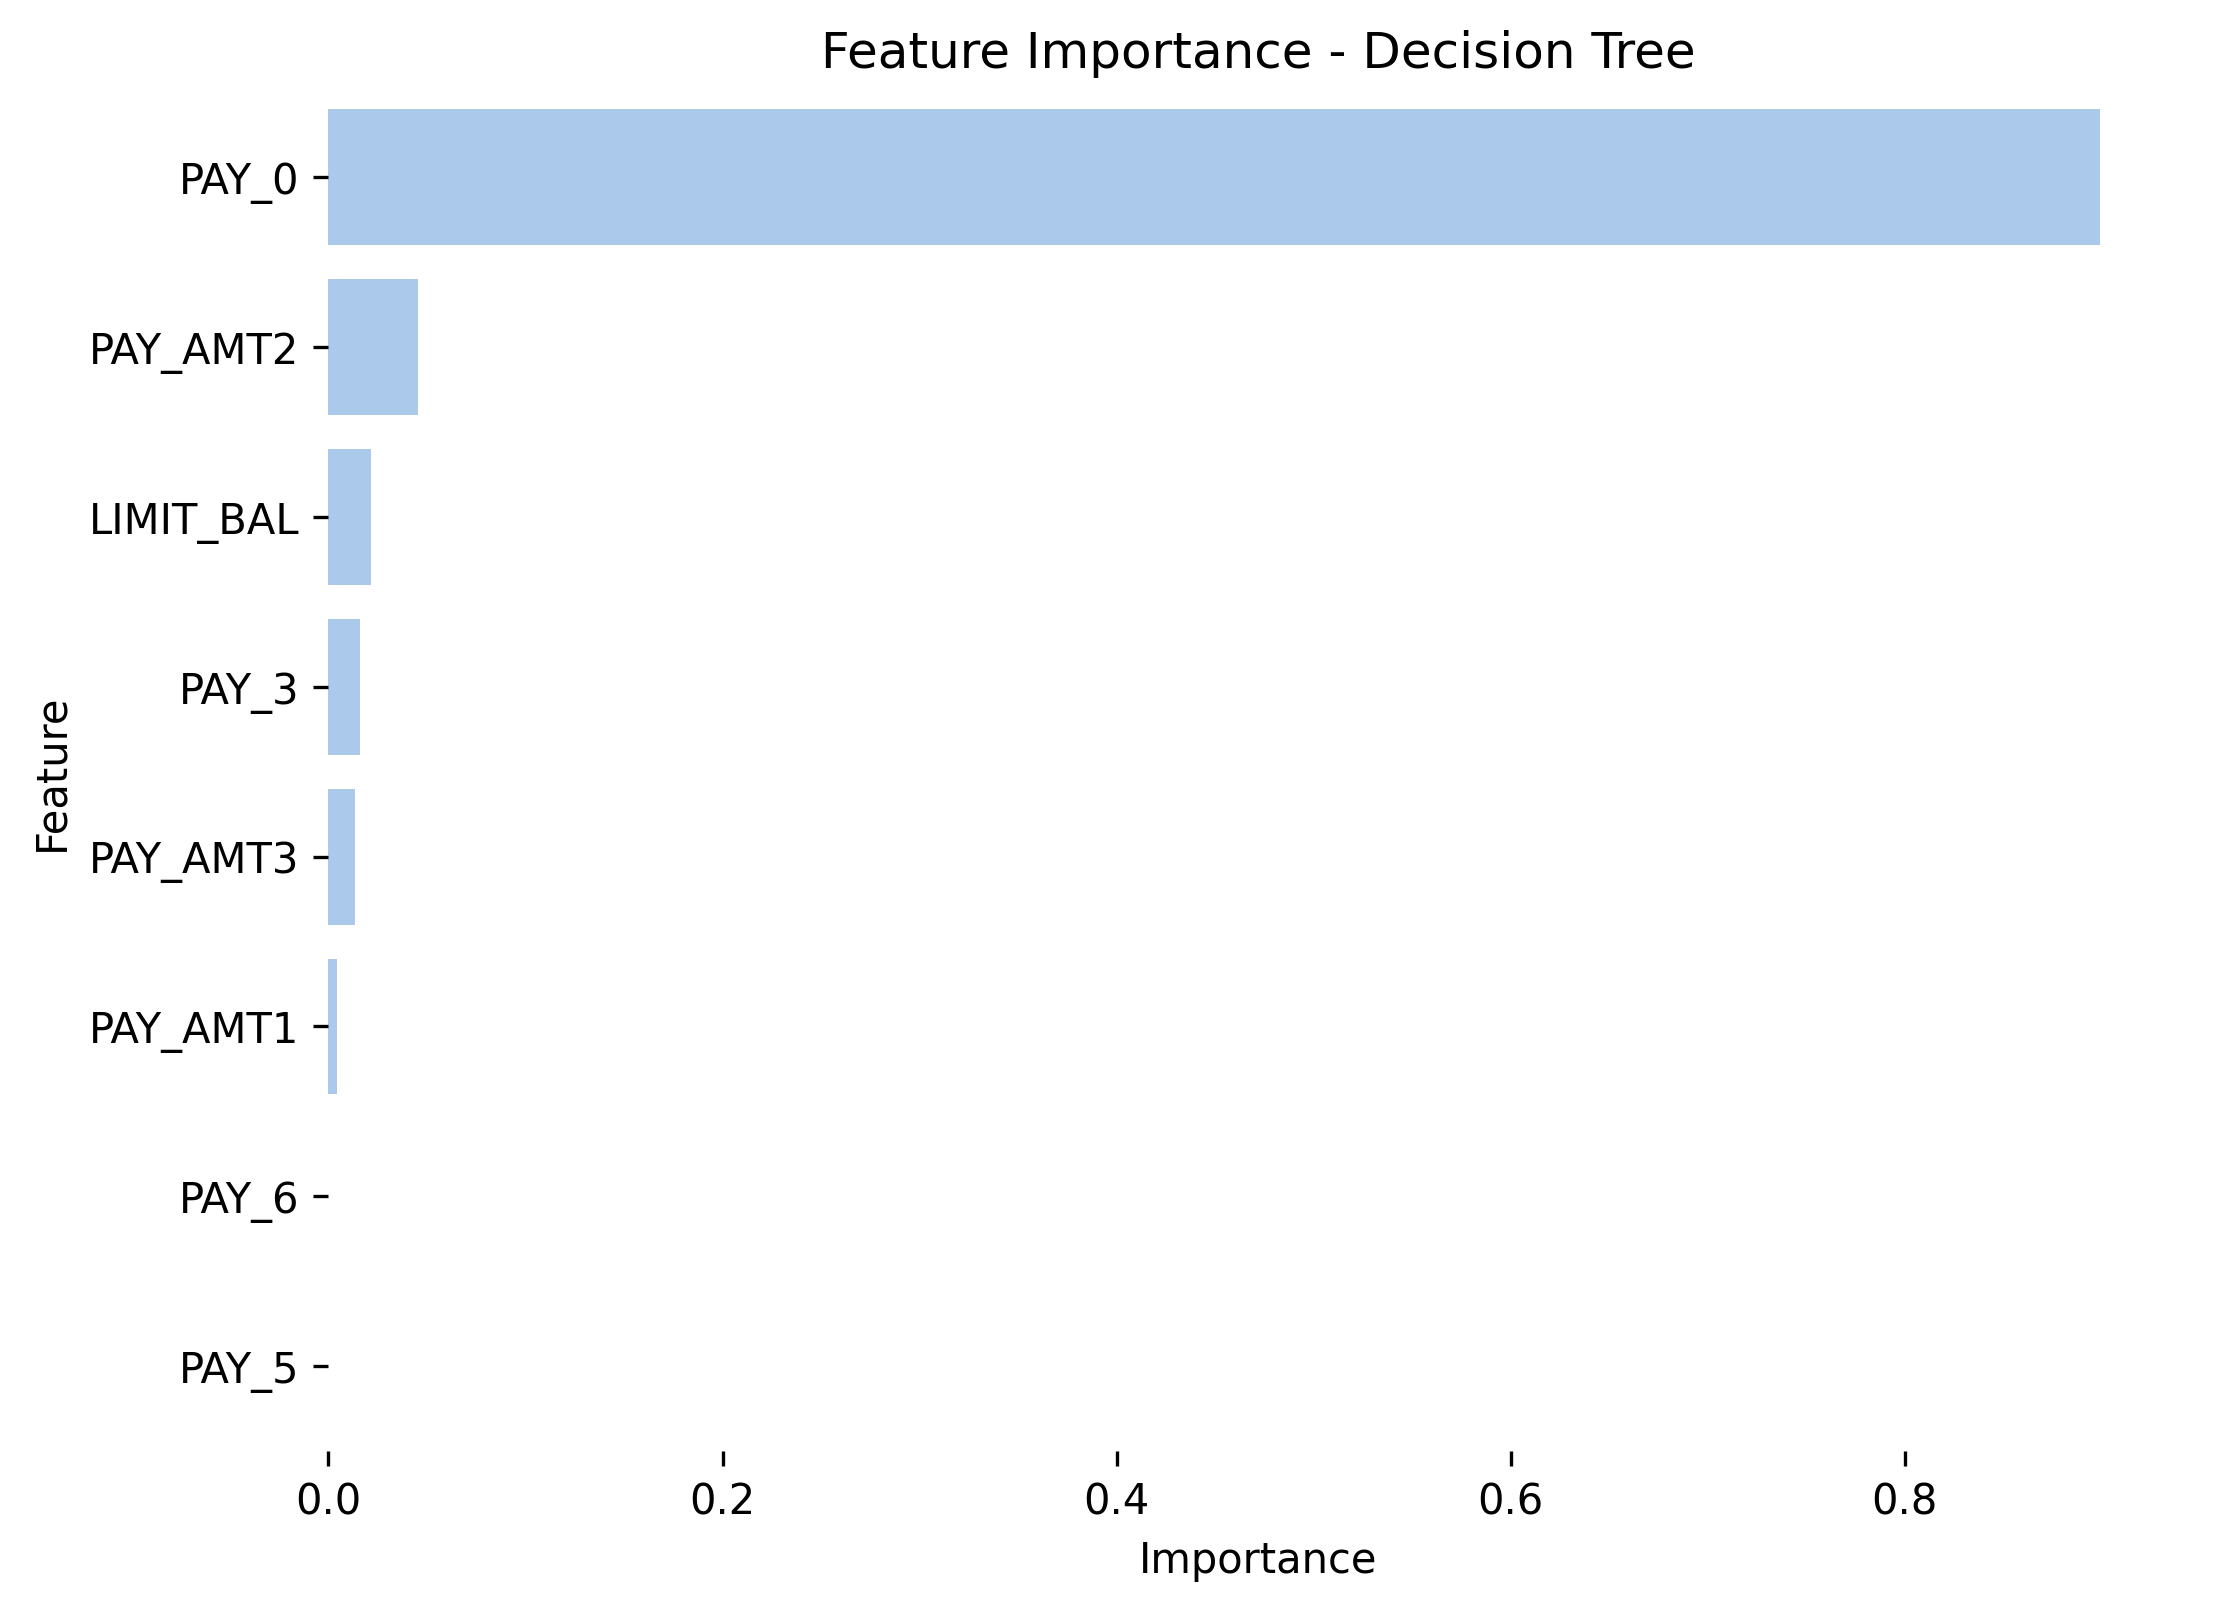

In [33]:
feat_labels = train[final_features].columns
importances = sk_dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

# plot feature importance
f, ax = plt.subplots(figsize=(8, 6), dpi=300)
plt.title("Feature Importance - Decision Tree")
sns.set_color_codes("pastel")
sns.barplot(y=[feat_labels[i] for i in indices], 
            x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Feature", xlabel="Importance")
sns.despine(left=True, bottom=True)
plt.savefig('dt_importances.png')

[0 1]


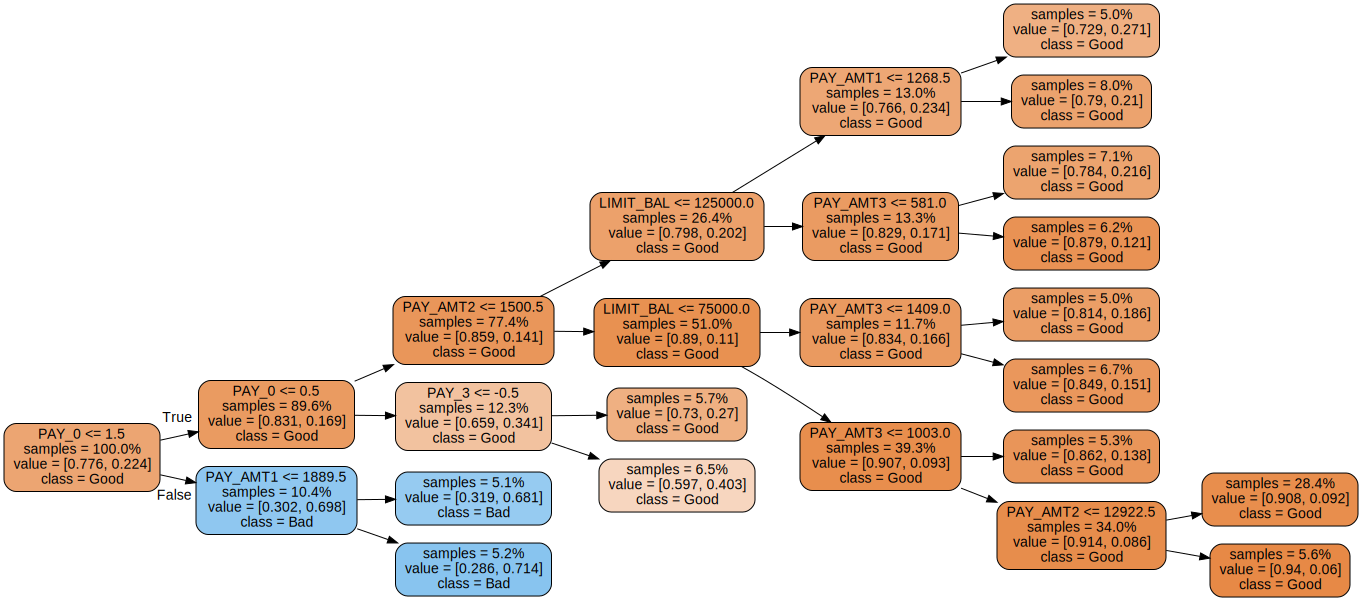

In [34]:
# assigning features and class labels for decision tree visualization
print(sk_dt_model.classes_)
class_labels = ['Good', 'Bad']

# drawing a tree
export_graphviz(
    sk_dt_model,
    out_file = 'tree_raw.dot',
    class_names = class_labels,
    feature_names=feat_labels,
    rotate=True,
    rounded=True,
    impurity=False,
    filled=True,
    proportion=True)

with open('tree_raw.dot') as f:
  dot_graph = f.read()

graphviz.Source(dot_graph)

In [35]:
# saving as png
png_bytes = graphviz.Source(dot_graph).pipe(format='png')
with open('tree_plot.png','wb') as f:
    f.write(png_bytes)

In [36]:
test_eval = pd.concat([test[final_features], test[target]], axis=1)
test_eval['pred'] = sk_dt_model.predict_proba(test_eval[final_features])[:, 1]
# worst bad leaf nodes
print(round(test_eval['pred'].nlargest(500).min(),3))
print(round(test_eval['pred'].nlargest(500).max(),3))

0.681
0.714


### Plotting ROC AUC curves

In [37]:
from matplotlib.gridspec import GridSpec
from sklearn.metrics import RocCurveDisplay

In [38]:
# model predictions to plot
clf_list = [
    (sk_lr_model, "Logistic"),
    (sk_dt_model, "Decision Tree"),
    (model, "AutoWoE"),
]

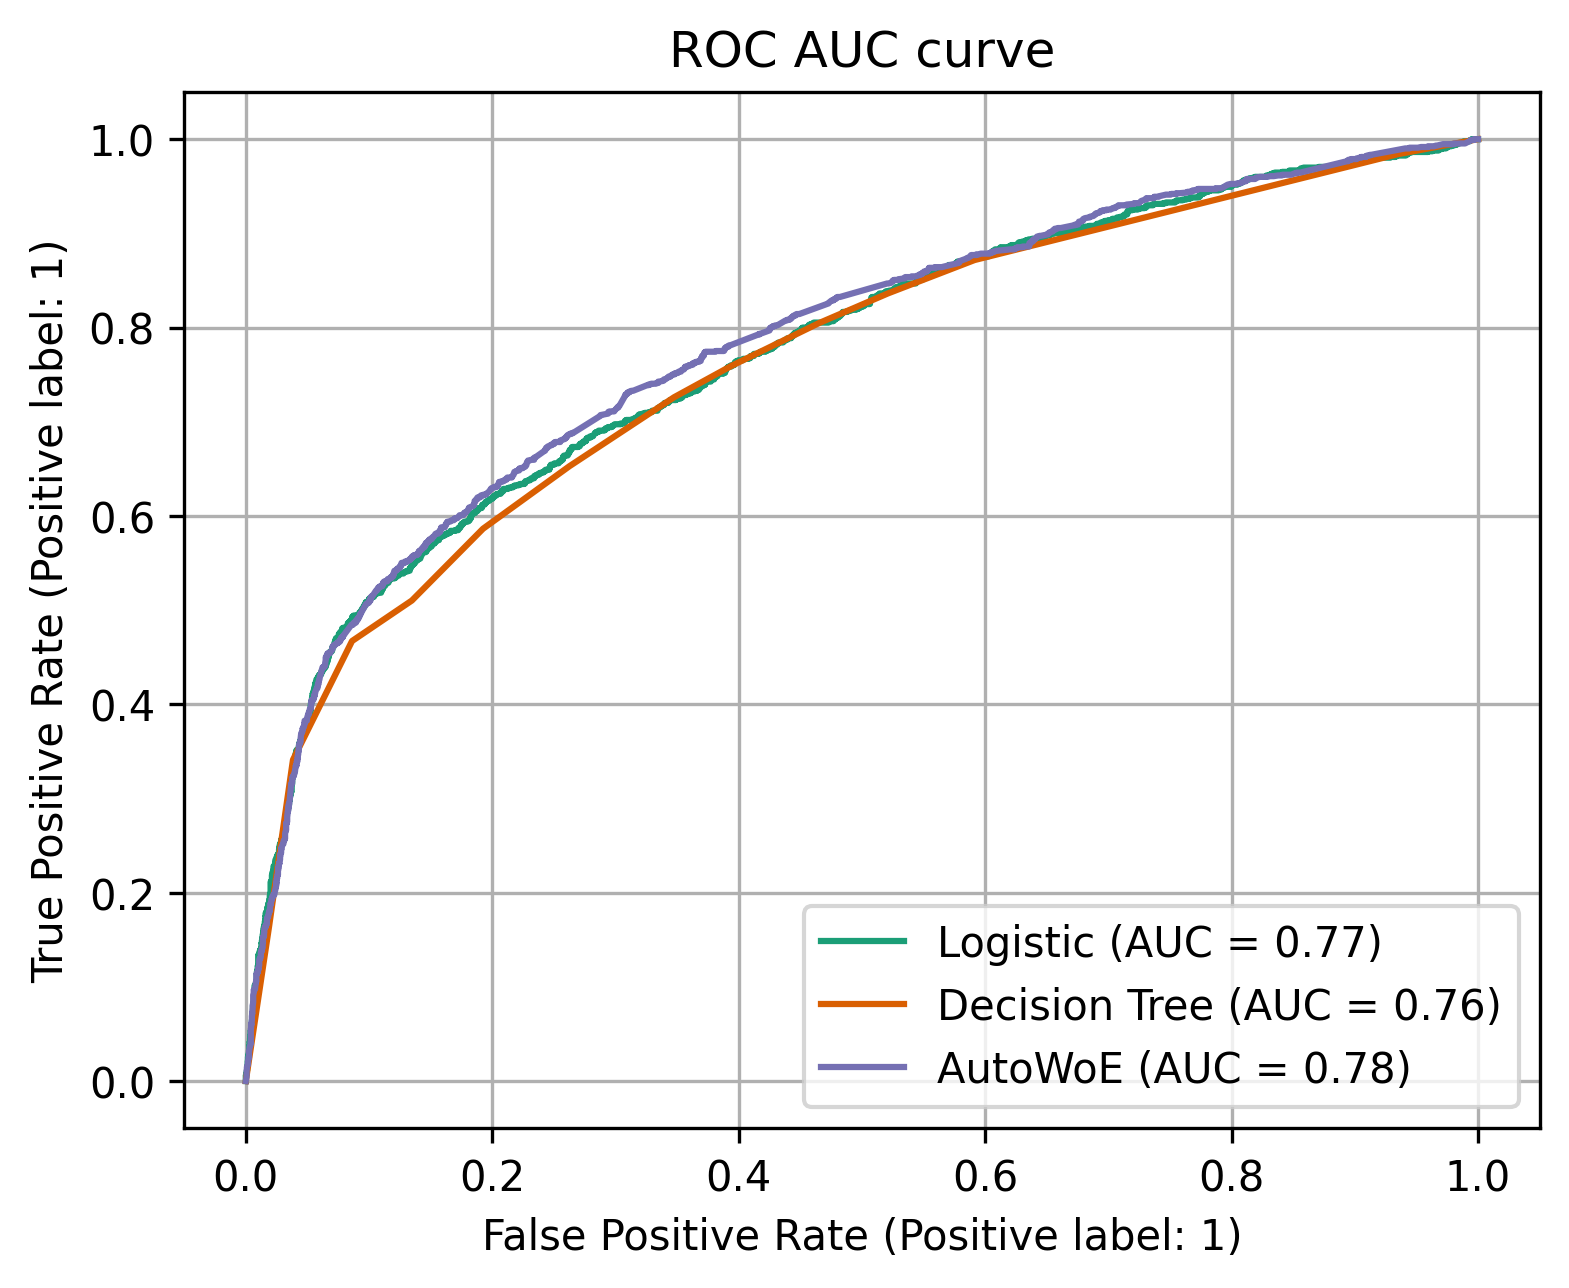

In [39]:
fig = plt.figure(figsize=(10, 8), dpi=300)
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

y_test = test[target]
X_test = test[final_features]

ax_roc_auc_curve = fig.add_subplot(gs[:3])
roc_auc_displays = {}

for i, (clf, name) in enumerate(clf_list):
    if name == 'AutoWoE':
        y_pred = clf.predict_proba(X_test)
    else:
        y_pred = clf.predict_proba(X_test)[:, 1]
    display = RocCurveDisplay.from_predictions(
    y_test, y_pred, ax=ax_roc_auc_curve, name=name, color=colors(i))
    roc_auc_displays[name] = display

ax_roc_auc_curve.grid()
ax_roc_auc_curve.set_title("ROC AUC curve")
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()

### Model parsimony

Validation raw feature selection derive further insights into the choice of risk drivers to understand whether a different set of features could be used in an alternative model based on the whole list of inputs

In [40]:
import sys
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

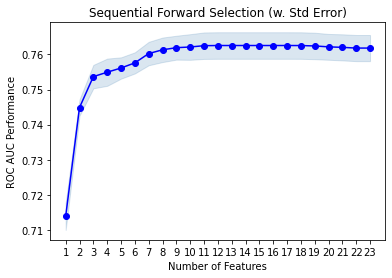

Selected features using SFS : ['PAY_0', 'PAY_2', 'PAY_3', 'LIMIT_BAL', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']
Development Gini : 52.26%
Validation Gini : 51.51%


In [41]:
# choosing cross-validation method for feature selection
fivefold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# building a challenger model using sequential forward feature selection
sfs_parsi_cv5 = sfs(
    sk_dt_model, 
    k_features='parsimonious',
    forward=True, 
    floating=False, 
    scoring='roc_auc', 
    verbose=0, 
    n_jobs=30, 
    cv=fivefold)

# training the model
sfs_parsi_cv5 = sfs_parsi_cv5.fit(development[features], development[target])

# plotting the feature selection process
plot_sfs(sfs_parsi_cv5.get_metric_dict(), kind='std_err', ylabel='ROC AUC Performance')
plt.title("Sequential Forward Selection (w. Std Error)")
plt.savefig('sfs_feature_selection.png', dpi=300)
plt.show()

# getting the features included in the parsimonious model
selected_features = list(sfs_parsi_cv5.k_feature_names_)
print(f"Selected features using SFS : {selected_features}")
print(f"Development Gini : {sfs_parsi_cv5.k_score_*2-1:.2%}")

# training an alternative model with the most informative features
sk_dt_model.fit(development[selected_features], development[target])
y_pred = sk_dt_model.predict_proba(validation[selected_features])[:, 1]
print(f"Validation Gini : {roc_auc_score(validation[target], y_pred)*2-1:.2%}")

In [42]:
# Reporting recommendations on potential features to be investigated
print(f"Potential features considered : {list(set(selected_features).intersection(final_features))}")
print(f"Potential features that are not considered : {list(set(selected_features) - set(final_features))}")

Potential features considered : ['PAY_AMT1', 'PAY_AMT3', 'LIMIT_BAL', 'PAY_0', 'PAY_AMT2', 'PAY_3']
Potential features that are not considered : ['PAY_2', 'BILL_AMT1']


### Model complexity

#### Validating model hyperparameters with Optuna

In [43]:
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

In [44]:
def objective(trial, X, y, cv, model_params):
    
    train_gini = []
    test_gini = []
    scores = []
    
    params = {
              "pearson_th"          : trial.suggest_categorical('pearson_th', [0.5, 0.7, 0.9]),
              "metric_th"           : trial.suggest_categorical('metric_th', [0.5, 0.55, 0.6]),
              "force_single_split"  : trial.suggest_categorical("force_single_split", [True,False]),
              "oof_woe"             : trial.suggest_categorical("oof_woe", [True, False]),
              "imp_type"            : trial.suggest_categorical("imp_type", ["feature_imp", "perm_imp"]),
              "p_val"               : trial.suggest_categorical("p_val", [0.01, 0.05, 0.1]),
      }
    
    # updating parameters and defining the model    
    params.update(model_params)
    autowoe = AutoWoE(**params)
    
    # aggregating X and Y along the column axis
    input_data = pd.concat([X, y], axis=1)
    
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        print(f"Fold {i}")
        train_set = input_data.iloc[train_index]
        test_set = input_data.iloc[test_index]
        # fitting the model
        autowoe.fit(
            train_set[final_features + [target]], 
            target_name=str(target),
            group_kf=None,
            validation=test_set)     
        print(f"Fold {i}: Fit complete")
        # making predictions
        train_predictions = autowoe.predict_proba(train_set[final_features])
        test_predictions = autowoe.predict_proba(test_set[final_features])
        # calculating Gini
        train_score = roc_auc_score(train_set[target], train_predictions)*2-1
        test_score = roc_auc_score(test_set[target], test_predictions)*2-1
        print(f"Train Gini : {train_score:.2%}")
        print(f"Test Gini : {test_score:.2%}")          
        train_gini.append(train_score)
        test_gini.append(test_score)
        # calculating a model score
        train_err = 1 - train_score
        test_err = 1 - test_score
        score = test_score * abs(train_err / test_err)
        print(f"Fold {i} score: {score:.2%}")
        scores.append(score)
      
    mean_score = np.mean(scores)
    mean_gini = np.mean(test_gini)

    print(f"Hyperparameters: {params}",
          f"Gini: {mean_gini}",
          f"Score: {mean_score}")
    
    return mean_score

In [45]:
# testing on validation data
X = validation[final_features]
y = validation[target]

# static hyperparameters we do not tune
hyperparameters = {
  "task"                       :"BIN",
  "interpreted_model"          : True,
  "monotonic"                  : True,          
  "max_bin_count"              : 5,
  "select_type"                : None,          
  "vif_th"                     : 10.,
  "imp_th"                     : 0,
  "th_const"                   : 32,   
  "th_nan"                     : 0.01,
  "th_cat"                     : 0.005,
  "woe_diff_th"                : 0.01,
  "min_bin_size"               : 0.01,
  "min_bin_mults"              : (2, 4),
  "min_gains_to_split"         : (0.0, 0.5, 1.0),
  "auc_tol"                    : 1e-4,
  "cat_alpha"                  : 100,
  "cat_merge_to"               : "to_woe_0",
  "nan_merge_to"               : "to_woe_0",
  "n_folds"                    : 6,
  "n_jobs"                     : 4,
  "l1_grid_size"               : 20,
  "l1_exp_scale"               : 6,
  "regularized_refit"          : False,
  "debug"                      : False,
  "verbose"                    : 0
  }

# search runs to retrieve the best model
sampler = TPESampler(seed=72)
study = optuna.create_study(sampler=sampler, direction="maximize")
func = lambda trial: objective(trial, X, y, skf, hyperparameters)
study.optimize(func, n_trials=5)

[I 2022-11-21 19:29:00,743] A new study created in memory with name: no-name-65f3ecf0-965f-4e30-98e5-2ffe927ddfeb


Fold 0
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
Fold 0: Fit complete
Train Gini : 50.75%
Test Gini : 43.08%
Fold 0 score: 37.27%
Fold 1
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
Fold 1: Fit complete
Train Gini : 40.90%
Test Gini : 45.18%
Fold 1 score: 48.70%
Fold 2
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
Fold 2: Fit complete
Train Gini : 47.73%
Test Gini : 52.45%
Fold 2 score: 57.66%
Fold 3
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
Fold 3: Fit complete
Train Gini : 41.81%
Test Gini : 44.49%
Fold 3 score: 46.64%
Fold 4
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
Fold 4: Fit

[I 2022-11-21 19:29:29,884] Trial 0 finished with value: 0.4863753190950198 and parameters: {'pearson_th': 0.7, 'metric_th': 0.6, 'force_single_split': True, 'oof_woe': False, 'imp_type': 'perm_imp', 'p_val': 0.01}. Best is trial 0 with value: 0.4863753190950198.


Fold 9: Fit complete
Train Gini : 49.62%
Test Gini : 47.29%
Fold 9 score: 45.20%
Hyperparameters: {'pearson_th': 0.7, 'metric_th': 0.6, 'force_single_split': True, 'oof_woe': False, 'imp_type': 'perm_imp', 'p_val': 0.01, 'task': 'BIN', 'interpreted_model': True, 'monotonic': True, 'max_bin_count': 5, 'select_type': None, 'vif_th': 10.0, 'imp_th': 0, 'th_const': 32, 'th_nan': 0.01, 'th_cat': 0.005, 'woe_diff_th': 0.01, 'min_bin_size': 0.01, 'min_bin_mults': (2, 4), 'min_gains_to_split': (0.0, 0.5, 1.0), 'auc_tol': 0.0001, 'cat_alpha': 100, 'cat_merge_to': 'to_woe_0', 'nan_merge_to': 'to_woe_0', 'n_folds': 6, 'n_jobs': 4, 'l1_grid_size': 20, 'l1_exp_scale': 6, 'regularized_refit': False, 'debug': False, 'verbose': 0} Gini: 0.4658562691671838 Score: 0.4863753190950198
Fold 0
[LightGBM] [Info] Number of positive: 934, number of negative: 3386
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remov

[I 2022-11-21 19:30:10,959] Trial 1 finished with value: 0.5191214251954023 and parameters: {'pearson_th': 0.9, 'metric_th': 0.55, 'force_single_split': False, 'oof_woe': False, 'imp_type': 'feature_imp', 'p_val': 0.1}. Best is trial 1 with value: 0.5191214251954023.


Fold 9: Fit complete
Train Gini : 49.62%
Test Gini : 47.29%
Fold 9 score: 45.20%
Hyperparameters: {'pearson_th': 0.9, 'metric_th': 0.55, 'force_single_split': False, 'oof_woe': False, 'imp_type': 'feature_imp', 'p_val': 0.1, 'task': 'BIN', 'interpreted_model': True, 'monotonic': True, 'max_bin_count': 5, 'select_type': None, 'vif_th': 10.0, 'imp_th': 0, 'th_const': 32, 'th_nan': 0.01, 'th_cat': 0.005, 'woe_diff_th': 0.01, 'min_bin_size': 0.01, 'min_bin_mults': (2, 4), 'min_gains_to_split': (0.0, 0.5, 1.0), 'auc_tol': 0.0001, 'cat_alpha': 100, 'cat_merge_to': 'to_woe_0', 'nan_merge_to': 'to_woe_0', 'n_folds': 6, 'n_jobs': 4, 'l1_grid_size': 20, 'l1_exp_scale': 6, 'regularized_refit': False, 'debug': False, 'verbose': 0} Gini: 0.503817219434918 Score: 0.5191214251954023
Fold 0
[LightGBM] [Info] Number of positive: 934, number of negative: 3386
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to re

[I 2022-11-21 19:30:50,303] Trial 2 finished with value: 0.5307402298510921 and parameters: {'pearson_th': 0.5, 'metric_th': 0.5, 'force_single_split': True, 'oof_woe': False, 'imp_type': 'feature_imp', 'p_val': 0.1}. Best is trial 2 with value: 0.5307402298510921.


Fold 9: Fit complete
Train Gini : 50.53%
Test Gini : 49.58%
Fold 9 score: 48.65%
Hyperparameters: {'pearson_th': 0.5, 'metric_th': 0.5, 'force_single_split': True, 'oof_woe': False, 'imp_type': 'feature_imp', 'p_val': 0.1, 'task': 'BIN', 'interpreted_model': True, 'monotonic': True, 'max_bin_count': 5, 'select_type': None, 'vif_th': 10.0, 'imp_th': 0, 'th_const': 32, 'th_nan': 0.01, 'th_cat': 0.005, 'woe_diff_th': 0.01, 'min_bin_size': 0.01, 'min_bin_mults': (2, 4), 'min_gains_to_split': (0.0, 0.5, 1.0), 'auc_tol': 0.0001, 'cat_alpha': 100, 'cat_merge_to': 'to_woe_0', 'nan_merge_to': 'to_woe_0', 'n_folds': 6, 'n_jobs': 4, 'l1_grid_size': 20, 'l1_exp_scale': 6, 'regularized_refit': False, 'debug': False, 'verbose': 0} Gini: 0.5110746600034196 Score: 0.5307402298510921
Fold 0
[LightGBM] [Info] Number of positive: 934, number of negative: 3386
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_col_wise=true` to rem

[I 2022-11-21 19:31:28,623] Trial 3 finished with value: 0.48377201950457166 and parameters: {'pearson_th': 0.5, 'metric_th': 0.5, 'force_single_split': True, 'oof_woe': False, 'imp_type': 'feature_imp', 'p_val': 0.01}. Best is trial 2 with value: 0.5307402298510921.


Fold 9: Fit complete
Train Gini : 49.77%
Test Gini : 47.81%
Fold 9 score: 46.00%
Hyperparameters: {'pearson_th': 0.5, 'metric_th': 0.5, 'force_single_split': True, 'oof_woe': False, 'imp_type': 'feature_imp', 'p_val': 0.01, 'task': 'BIN', 'interpreted_model': True, 'monotonic': True, 'max_bin_count': 5, 'select_type': None, 'vif_th': 10.0, 'imp_th': 0, 'th_const': 32, 'th_nan': 0.01, 'th_cat': 0.005, 'woe_diff_th': 0.01, 'min_bin_size': 0.01, 'min_bin_mults': (2, 4), 'min_gains_to_split': (0.0, 0.5, 1.0), 'auc_tol': 0.0001, 'cat_alpha': 100, 'cat_merge_to': 'to_woe_0', 'nan_merge_to': 'to_woe_0', 'n_folds': 6, 'n_jobs': 4, 'l1_grid_size': 20, 'l1_exp_scale': 6, 'regularized_refit': False, 'debug': False, 'verbose': 0} Gini: 0.4645791240782039 Score: 0.48377201950457166
Fold 0
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
Fold 0: Fit complete
Train Gini : 50.75%
Test Gini : 43.08%
Fold 0 score: 37.27%
Fold 1

[I 2022-11-21 19:31:59,433] Trial 4 finished with value: 0.5083842007012561 and parameters: {'pearson_th': 0.9, 'metric_th': 0.6, 'force_single_split': True, 'oof_woe': False, 'imp_type': 'perm_imp', 'p_val': 0.05}. Best is trial 2 with value: 0.5307402298510921.


Fold 9: Fit complete
Train Gini : 49.62%
Test Gini : 47.29%
Fold 9 score: 45.20%
Hyperparameters: {'pearson_th': 0.9, 'metric_th': 0.6, 'force_single_split': True, 'oof_woe': False, 'imp_type': 'perm_imp', 'p_val': 0.05, 'task': 'BIN', 'interpreted_model': True, 'monotonic': True, 'max_bin_count': 5, 'select_type': None, 'vif_th': 10.0, 'imp_th': 0, 'th_const': 32, 'th_nan': 0.01, 'th_cat': 0.005, 'woe_diff_th': 0.01, 'min_bin_size': 0.01, 'min_bin_mults': (2, 4), 'min_gains_to_split': (0.0, 0.5, 1.0), 'auc_tol': 0.0001, 'cat_alpha': 100, 'cat_merge_to': 'to_woe_0', 'nan_merge_to': 'to_woe_0', 'n_folds': 6, 'n_jobs': 4, 'l1_grid_size': 20, 'l1_exp_scale': 6, 'regularized_refit': False, 'debug': False, 'verbose': 0} Gini: 0.4893086400579631 Score: 0.5083842007012561


In [46]:
best_hyperparameters = study.best_trial.params
print(f"Best value: {study.best_value:.2%}, Best params: {best_hyperparameters}")

Best value: 53.07%, Best params: {'pearson_th': 0.5, 'metric_th': 0.5, 'force_single_split': True, 'oof_woe': False, 'imp_type': 'feature_imp', 'p_val': 0.1}


In [47]:
fig = plot_parallel_coordinate(study)
fig.show()

In [48]:
# report plots
fig = plot_param_importances(study)
fig.show()

In [49]:
# retraining based on the best parameters
autowoe_best = AutoWoE(**best_hyperparameters)

# fitting the model
autowoe_best.fit(
    validation[final_features + [target]], 
    target_name=str(target),
    group_kf=None,
    validation=test)

# testing discriminatory power
y_pred = autowoe_best.predict_proba(test)
print(f"Validation Test Gini : {roc_auc_score(test[target], y_pred)*2-1:.2%}")

# testing discriminatory power
y_pred = model.predict_proba(test)
print(f"Development Test Gini : {roc_auc_score(test[target], y_pred)*2-1:.2%}")

[LightGBM] [Info] Number of positive: 1013, number of negative: 3787
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211042 -> initscore=-1.318658
[LightGBM] [Info] Start training from score -1.318658
PAY_0 processing...
LIMIT_BAL processing...
PAY_AMT2 processing...
PAY_AMT1 processing...
PAY_3 processing...
PAY_5 processing...
PAY_AMT3 processing...
PAY_6 processing...
dict_keys(['PAY_0', 'PAY_3', 'LIMIT_BAL', 'PAY_AMT1', 'PAY_5', 'PAY_AMT2', 'PAY_AMT3', 'PAY_6']) to selector !!!!!
Feature selection...
PAY_0       -0.748906
PAY_3       -0.308126
PAY_AMT1    -0.488863
LIMIT_BAL   -0.382960
PAY_AMT2    -0.191314
PAY_6       -0.317707
PAY_AMT3    -0.219440
dtype: float64
Validation Test Gini : 54.72%
